
# HW4

**Scope:** Warm‑up → K‑Means → choosing *k* → DBSCAN → Hierarchical → compare.  
**Dataset:** Iris (built‑in).  


In [1]:

# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score

from scipy.cluster.hierarchy import linkage, dendrogram

plt.rcParams['figure.figsize'] = (6,4)
np.random.seed(0)
print("✅ Environment ready")


✅ Environment ready



## Part 1: Warm‑up: Load, Scale, and Inspect 

**Why scaling?** Distance‑based algorithms (K‑Means, DBSCAN with Euclidean metric, Ward’s hierarchical) can be dominated by features with larger numeric ranges.


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Shape: (150, 4)
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


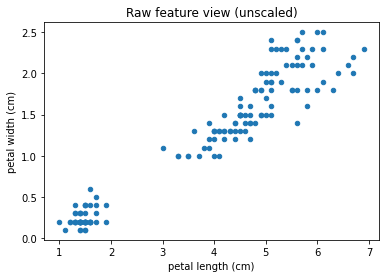

In [11]:

# Load Iris
iris = load_iris(as_frame=True)
X_df = iris.data.copy()     # DataFrame for readability
y = iris.target.values      # labels for optional ARI

display(X_df.describe())
print("Shape:", X_df.shape)
print("Features:", list(X_df.columns))

# Standardize for algorithms
scaler = StandardScaler().fit(X_df.values)
X = scaler.transform(X_df.values)

# We'll use two raw features for simple 2D plots (no PCA)
feat_x, feat_y = "petal length (cm)", "petal width (cm)"
ix, iy = list(X_df.columns).index(feat_x), list(X_df.columns).index(feat_y)

# Quick 2D scatter in raw (unscaled) coordinates for intuition
plt.scatter(X_df.iloc[:, ix], X_df.iloc[:, iy], s=20)
plt.xlabel(feat_x); plt.ylabel(feat_y); plt.title("Raw feature view (unscaled)")
plt.show()



**Q1:** Explain why scaling features can change the result of distance‑based clustering. Give one concrete failure mode if you **skip** scaling.



## Part 2: K‑Means (k = 3)

**Mini‑explanations:**  
- **K‑Means** groups points by minimizing within‑cluster squared distances.  
- **Inertia** ↓ with larger *k* (monotonic).  
- **Silhouette** in \[-1,1\]: higher means points are closer to their own cluster than to other clusters.


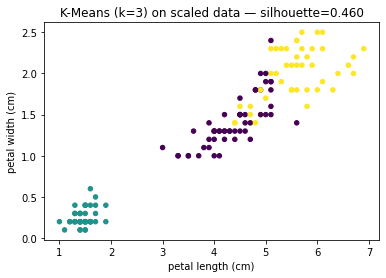

Inertia (k=3): 139.82


In [4]:

km3 = KMeans(n_clusters=3, n_init=10, random_state=0).fit(X)
labels3 = km3.labels_
sil3 = silhouette_score(X, labels3)

# Visualize using two raw features; color by K-Means labels
plt.scatter(X_df.iloc[:, ix], X_df.iloc[:, iy], c=labels3, s=20)
plt.xlabel(feat_x); plt.ylabel(feat_y)
plt.title(f"K-Means (k=3) on scaled data — silhouette={sil3:.3f}")
plt.show()

print(f"Inertia (k=3): {km3.inertia_:.2f}")



**Q2:** What does a **high** silhouette imply about cohesion and separation? Why might the 2D scatter above look clean while the silhouette is mediocre?



## Part 3: Choosing the Number of Clusters *k* (Elbow + Silhouette)

**Guidance:**  
- **Inertia**: sum of squared distances to the assigned centroid (↓ is better, but always decreases as k↑).  
- **Silhouette**: (b − a) / max(a, b) where *a* is mean intra‑cluster distance, *b* is mean distance to nearest other cluster. Ranges \[-1, 1\]; higher is better. 
- When they disagree, weigh **interpretability** and **stability** across runs.


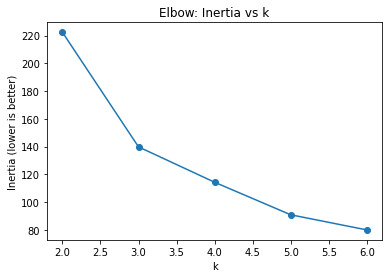

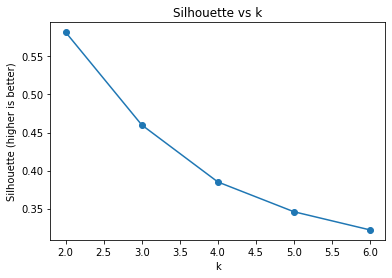

k  | inertia     | silhouette
2  | 222.36     | 0.582
3  | 139.82     | 0.460
4  | 114.35     | 0.385
5  | 90.93      | 0.346
6  | 80.02      | 0.322


In [ ]:

ks = range(2, 7)
inertias, sils = [], []

for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=0).fit(X)
    labels = km.labels_
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X, labels))

# Plot elbow
plt.plot(list(ks), inertias, marker='o')
plt.xlabel("k"); plt.ylabel("Inertia (lower is better)")
plt.title("Elbow: Inertia vs k")
plt.show()

# Plot silhouette
plt.plot(list(ks), sils, marker='o')
plt.xlabel("k"); plt.ylabel("Silhouette (higher is better)")
plt.title("Silhouette vs k")
plt.show()

print("k  | inertia     | silhouette")
for k, inn, si in zip(ks, inertias, sils):
    print(f"{k:<3}| {inn:<11.2f}| {si:.3f}")



**Q3:** Pick a **k** you find reasonable and justify it using both plots. If your choice differs from the highest‑silhouette value, explain why.



## Part 4: Density‑Based Clustering with DBSCAN 

**DBSCAN basics:**  
- **eps**: neighborhood radius; **min_samples**: minimum points to form a dense region.  
- Labels: core clusters get 0..C−1; **noise points** are labeled **−1**.  
- Pros: finds **arbitrary shapes** and flags noise; no need to choose *k*.  
- Cons: sensitive to **scaling** and parameter choice; one global density may struggle when clusters differ in density.


In [7]:

def run_dbscan_grid(X, eps_list, ms_list):
    rows = []
    for e in eps_list:
        for m in ms_list:
            db = DBSCAN(eps=e, min_samples=m).fit(X)
            labels = db.labels_
            n_noise = int(np.sum(labels == -1))
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            sil = np.nan
            if n_clusters > 1:
                try:
                    from sklearn.metrics import silhouette_score
                    sil = silhouette_score(X, labels)
                except Exception:
                    sil = np.nan
            rows.append({"eps": e, "min_samples": m, "n_clusters": n_clusters, "n_noise": n_noise, "silhouette": sil})
    return pd.DataFrame(rows).sort_values(["n_clusters","silhouette"], ascending=[False, False]).reset_index(drop=True)

eps_list = [0.2, 0.3, 0.4, 0.5]
ms_list  = [3, 5, 8]

grid = run_dbscan_grid(X, eps_list, ms_list)
display(grid.head(10))


,eps,min_samples,n_clusters,n_noise,silhouette
0,0.4,3,10,39,0.151251
1,0.3,3,10,84,-0.147300
2,0.5,3,7,17,0.159710
3,0.4,5,6,66,0.027670
4,0.2,3,5,133,0.087058
5,0.5,8,3,59,0.188217
6,0.3,5,3,120,-0.194195
7,0.5,5,2,34,0.356516
8,0.4,8,2,117,0.296706
9,0.3,8,2,131,0.156582



Pick **two** promising configurations from the table to visualize below.


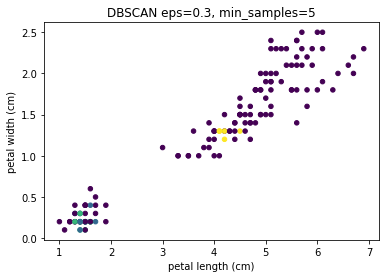

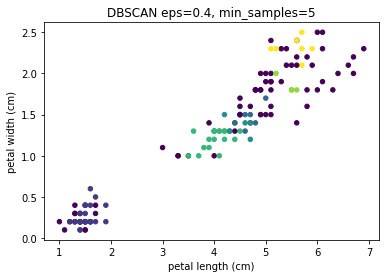

In [8]:

configs = [
    {"eps": 0.3, "min_samples": 5},
    {"eps": 0.4, "min_samples": 5},
]

for cfg in configs:
    db = DBSCAN(eps=cfg["eps"], min_samples=cfg["min_samples"]).fit(X)
    labels = db.labels_
    plt.scatter(X_df.iloc[:, ix], X_df.iloc[:, iy], c=labels, s=20)
    plt.xlabel(feat_x); plt.ylabel(feat_y)
    plt.title(f"DBSCAN eps={cfg['eps']}, min_samples={cfg['min_samples']}")
    plt.show()



**Q4:** How did changing **eps** and **min_samples** affect the **number of clusters** and **noise points**?


## Part 5: Hierarchical Clustering + Dendrogram

**Mini‑explanations:**  
- **Agglomerative clustering (Ward linkage)** starts with each point as its own cluster and merges pairs that minimally increase within‑cluster variance.  
- A **dendrogram** visualizes merge distances; a **horizontal cut** corresponds to choosing a number of clusters.  
- Like K‑Means, Ward linkage uses Euclidean geometry and benefits from scaling.


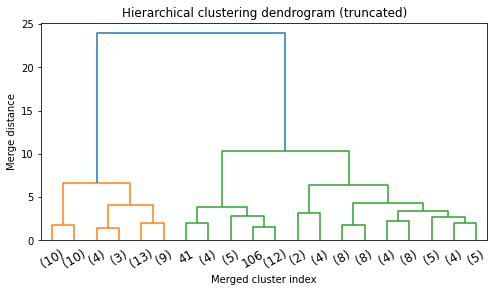

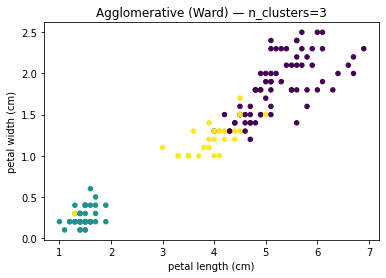

Silhouette (Agglomerative, n=3): 0.447


In [12]:

# Subsample for dendrogram readability
subset_n = 120
X_sub = X[:subset_n]

# Linkage matrix with Ward's method
Z_link = linkage(X_sub, method='ward')

# Dendrogram (truncated display)
plt.figure(figsize=(8, 4))
dendrogram(Z_link, truncate_mode='lastp', p=20, leaf_rotation=30)
plt.title("Hierarchical clustering dendrogram (truncated)")
plt.xlabel("Merged cluster index"); plt.ylabel("Merge distance")
plt.show()

# Choose a cut (set number of clusters) and fit Agglomerative on the full set
n_clusters = 3  # ← adjust after inspecting dendrogram if desired
agg = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
labels_agg = agg.fit_predict(X)

# Visualize on raw feature axes
plt.scatter(X_df.iloc[:, ix], X_df.iloc[:, iy], c=labels_agg, s=20)
plt.xlabel(feat_x); plt.ylabel(feat_y)
plt.title(f"Agglomerative (Ward) — n_clusters={n_clusters}")
plt.show()

# Optional silhouette for the chosen cut
if n_clusters > 1:
    sil_agg = silhouette_score(X, labels_agg)
    print(f"Silhouette (Agglomerative, n={n_clusters}): {sil_agg:.3f}")



**Q5:** Based on the dendrogram, explain how you chose the cut (number of clusters). Compare this hierarchical result to your best K‑Means result.
